In [1]:
import os
import string
import sys

import IPython
%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.pylab as plt
import pandas as pd

from collections import Counter
from itertools import islice
from multiprocessing import Pool
from pprint import pprint as pp

from util import timed

In [2]:
d = IPython.display.display
plot_config = {
    "colormap": lambda x:colors.hex2color("#3355ee"),
    "edgecolor" : colors.hex2color("#ffffff"),
    "grid":False,
    "kind":"bar",
    "legend": None
}

plot_rc = {
    'axes.titlesize' : 24,
    'font.family': 'monospace',
    'font.size' : 12
}

In [3]:
with open("ERR309932_1.fastq.head.txt", "r") as f: #"A gigabyte of RAM should do the trick."
    fastq = f.readlines()

In [4]:
calls = "".join(fastq[1::4]).translate(None,"\n")
confi = "".join(fastq[3::4]).translate(None,"\n")
(len(calls), calls[:10], confi[:10])

(485506000, 'NATGCTACTA', '!0<BB<FBFF')

In [5]:
quality = """!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"""


In [6]:
@timed
def pw(calls, confidence, threshhold):
    out = []
    ncalls = len(calls)
    for i in xrange(ncalls):
        if(quality.index(confidence[i]) > threshhold):
            out.append(calls[i])
            continue
        out.append('_')
    return "".join(out)

ocall = pw(calls[:1000000], confi[:1000000], 36)
(
 ocall[:100],
 confi[:100]
)

0:00:00.380713


('______A_TA_AT______AAA___A__AAAA____________________________________________________________________',
 "!0<BB<FBFFBFFBBBBB<FFFBBBFBBFFIF''7<'07'0'''00''077''0''0<<BBBB<<<B<0<'07'0'00<<'00'00000'0<B<<''0<'")

In [7]:
def mask(threshhold):
    threshhold+=1
    return " "*len(quality[:threshhold]) + quality[threshhold:]

to_ = string.maketrans(quality, mask(36))
tconf = confi.translate(to_)
def fall(call, confi):
    if confi == " ":
        return " "
    return call

def pw_substr_freq(pw, length):
    stats = Counter()
    for i in xrange(len(pw)-length+1):
        key = pw[i:i+length]
        #stats.update([(key.strip() or "_"*length).replace(" ", "_")])
        stats.update([(key.strip()).replace(" ", "_")])
    return stats

zero = pd.DataFrame()
def add_df(dfa, dfb):
    return dfa.add(dfb, fill_value=0)

def reduce_d(dataframes):
    return reduce(add_df, dataframes, zero)

def slice_d_factory(threshhold):
    def slice_d(data, lo, hi):
        to_ = string.maketrans(quality, mask(threshhold))
        offset = 1 - (lo % 4)
        olo = lo + offset
        num_calls = (hi-olo)//4
        conf_s = data[olo+2:hi+2:4]
        confi = "".join(conf_s).translate(None,"\n").translate(to_)
        #del(conf_s)
        call_s = "".join(data[olo:hi:4]).translate(None,"\n")
        calls = "".join((fall(call_s[i], confi[i]) for i in xrange(num_calls)))
        #del(calls)
        return calls
    return slice_d

def map_d(calls, length):
    out_df = pd.DataFrame(pw_substr_freq(calls, length).most_common(30))
    return pd.DataFrame(list(out_df.T.ix[1]), index=out_df.T.ix[0])

def map_d_factory(length):
    def map_d(calls):
        out_df = pd.DataFrame(pw_substr_freq(calls, length).most_common(30))
        return pd.DataFrame(list(out_df.T.ix[1]), index=out_df.T.ix[0])
    return map_d

@timed
def job(data, map_, reduce_, slice_=None, nworkers=8, maxtasksperchild=8):
    if(not slice_):
        def slice_(data, lo, hi):
            return data[lo:hi]
    datalen = len(data)
    workers = Pool(nworkers, maxtasksperchild=maxtasksperchild)
    cuts = [(int(i*datalen/nworkers), int((i+1)*datalen/nworkers)) for i in xrange(nworkers)]
    chunks = [slice_(data,lo,hi) for (lo,hi) in cuts]
    mapped = workers.map(map_, chunks)
    return reduce_(mapped)

In [8]:
to_ = string.maketrans(quality, mask(35))
tconf = confi.translate(to_)
tcall = timed(lambda:"".join([fall(calls[i], tconf[i]) for i in xrange(1000000)]))()
(
 tcall[:100],
 confi[:100]
)

0:00:00.245875


('      A TA AT      AAA   A  AAAA                                                                    ',
 "!0<BB<FBFFBFFBBBBB<FFFBBBFBBFFIF''7<'07'0'''00''077''0''0<<BBBB<<<B<0<'07'0'00<<'00'00000'0<B<<''0<'")

In [9]:
#a = pw_substr_freq(tcall[:10000000], 8) #~:45
a = timed(lambda:pw_substr_freq(tcall[:62500], 8))() #~:.5
pd.DataFrame(a.most_common(6)).T

0:00:00.253739


0    1    2    3    4    5
0           T    A    G    C   TT
1  10034  984  787  503  371  214

# Job #

In [10]:
frames = []
map_d = map_d_factory(8)
for threshh in [31, 34, 39]:#range(30,40,1):
    slice_d = slice_d_factory(threshh)
    frames.append(job(fastq, map_d, reduce_d, slice_=slice_d, nworkers=32).sort(0,ascending=False))

0:00:07.378100
0:00:08.038047
0:00:07.803211


In [11]:
[d(frame[0:20].T) for frame in frames]

0            A     T     G     C    TT  TTTTTTTT    AA  AAAAAAAA    CC    GG  \
0  47344  7918  7354  6353  6034  2271      2145  2134      1750  1552  1372   

0  AATGGAAT  GAATGGAA   TG   AG  AAA  ATTCCATT   AT  TTT  TTCCATTC  
0      1187      1005  996  931  901       824  797  784       730

0              T      A      G      C    TT    AA    GG    AT    AG    TA  \
0  266741  24796  20686  14215  11642  5584  4417  3255  2707  2667  2650   

0    TG    CC    CA   TTT    TC    CT   AAA  TTTTTTTT    AC  
0  2618  2462  1978  1965  1912  1814  1480      1408  1326

0               A      T     G     C    TT    AA    AG    GG    TG    AT  \
0  1509651  11219  10843  8911  6671  2953  2828  1936  1892  1863  1658   

0    CA    TA    CT    TC    CC   AAA    AC    GA   TTT  
0  1616  1332  1324  1237  1176  1133  1125  1030  1015

[None, None, None]

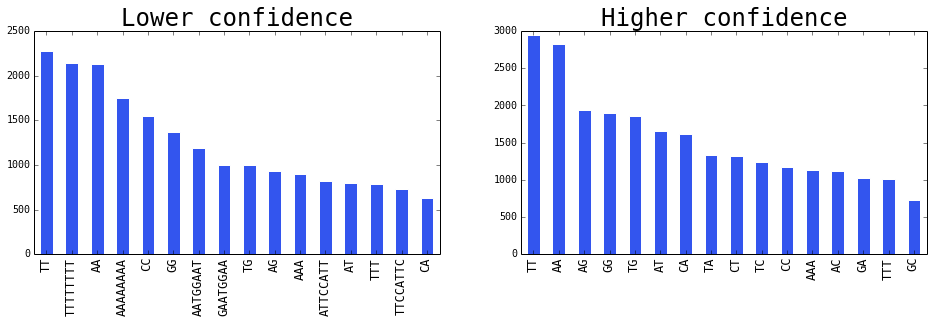

In [12]:
with matplotlib.pyplot.rc_context(rc=plot_rc): 
    fig, axs = plt.subplots(ncols=2)
    fig.set_figwidth(16)
    fig.set_figheight(4)
    df_lo = frames[0]
    df_hi = frames[-1]
    df_lo[5:21].plot(ax=axs[0], x=df_lo[5:21].index, **plot_config)
    df_hi[5:21].plot(ax=axs[1], x=df_hi[5:21].index, **plot_config)
    axs[0].set_title("Lower confidence", fontdict={"fontsize":24})
    axs[0].set_xlabel("")
    axs[1].set_title("Higher confidence")
    axs[1].set_xlabel("")

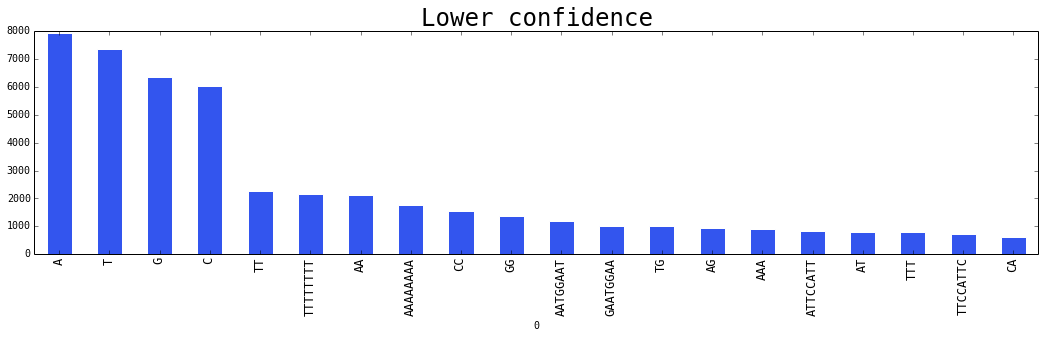

In [13]:
with matplotlib.pyplot.rc_context(rc=plot_rc): 
    fig, axs = plt.subplots(ncols=1)
    fig.set_figwidth(18)
    fig.set_figheight(4)
    plot_data = frames[0][1:21]
    plot_data.plot(ax=axs, title="Lower confidence", x=plot_data[:20].index, **plot_config)

In [14]:
def sift(index, negate=False):
    def test(i):
        out = len(i)>1
        if(negate):
            out = not out
        return out
    return pd.Index([test(i) for i in index])

In [15]:
d(plot_data[sift(plot_data.index, negate=False)].T)
sum(plot_data[sift(plot_data.index, negate=False)][0])

0    TT  TTTTTTTT    AA  AAAAAAAA    CC    GG  AATGGAAT  GAATGGAA   TG   AG  \
0  2271      2145  2134      1750  1552  1372      1187      1005  996  931   

0  AAA  ATTCCATT   AT  TTT  TTCCATTC   CA  
0  901       824  797  784       730  628

20007.0

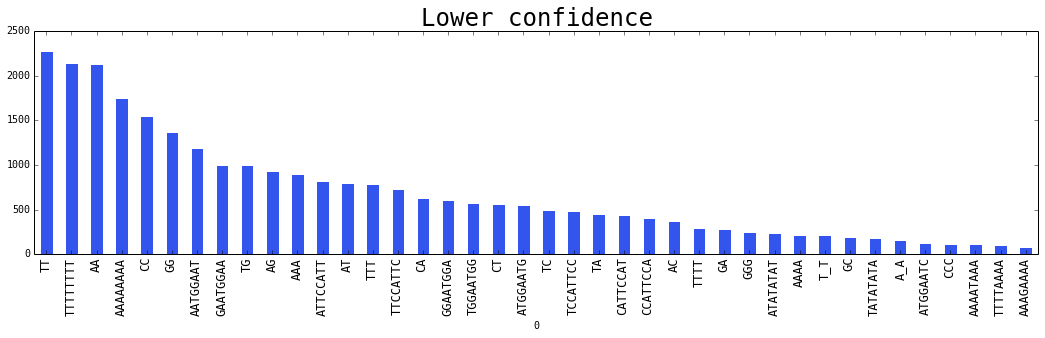

In [16]:
plot_data_ = frames[0][sift(frames[0].index)]

with matplotlib.pyplot.rc_context(rc=plot_rc): 
    fig, axs = plt.subplots(ncols=1)
    fig.set_figwidth(18)
    fig.set_figheight(4)
    plot_data_.T
    plot_data_[:40].plot(ax=axs, title="Lower confidence", x=plot_data_.index[:40], **plot_config)

# Lengthy

In [17]:
framesl = []
map_d = map_d_factory(16)
for threshh in [31]:#, 34, 39]:#range(30,40,1):
    slice_d = slice_d_factory(threshh)
    framesl.append(job(fastq, map_d, reduce_d, slice_=slice_d, nworkers=32).sort(0,ascending=False))

0:00:07.647693


47344.0

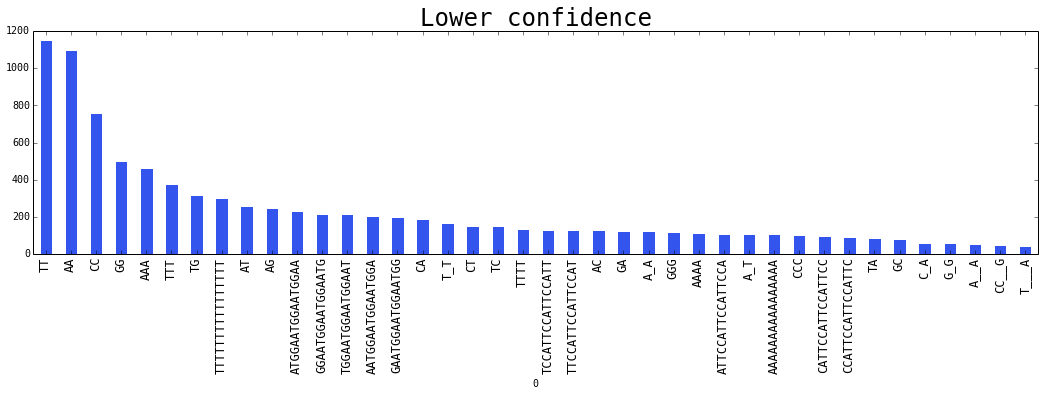

In [18]:
plot_data_ = framesl[0][5:]
d(frames[0].head(1)[0][0])

with matplotlib.pyplot.rc_context(rc=plot_rc): 
    fig, axs = plt.subplots(ncols=1)
    fig.set_figwidth(18)
    fig.set_figheight(4)
    plot_data_.T
    plot_data_[:40].plot(ax=axs, title="Lower confidence", x=plot_data_.index[:40], **plot_config)